# 光流：使用 RAFT 模型预测运动

光流是预测两幅图像之间运动的任务，通常是视频中连续两帧之间的运动。光流模型接受两幅图像作为输入，并预测流场：流场指示第一幅图像中每个像素的位移，并将其映射到第二幅图像中的相应像素。流场是 `(2, H, W)` 维张量，其中第一个轴对应于预测的水平位移和垂直位移。

以下示例说明了如何使用 {mod}`torchvision` 库中的 RAFT 模型实现来预测流场。我们还将看到如何将预测的流场转换为RGB图像以进行可视化。

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

## 使用 Torchvision 读取视频

首先将使用 {func}`torchvision.io.read_video` 函数来读取视频。或者，如果从源代码构建了 {mod}`torchvision`，也可以使用新的 {class}`torchvision.io.VideoReader` API。
我们将在这里使用的视频来自[pexels.com](https://www.pexels.com/video/a-man-playing-a-game-of-basketball-5192157/)，该视频可以免费使用，版权归[Pavel Danilyuk](https://www.pexels.com/@pavel-danilyuk)所有。

In [2]:
import tempfile
from pathlib import Path
from urllib.request import urlretrieve


video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
_ = urlretrieve(video_url, video_path)

{func}`~torchvision.io.read_video` 函数返回视频帧、音频帧以及与视频相关的元数据。在例子中，只需要视频帧。

这里我们将对两对预先选定的帧进行两次预测，即帧 `(100, 101)` 和 `(150, 151)`。每对帧对应一个模型输入。

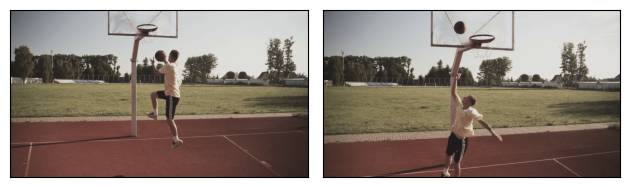

In [6]:
from torchvision.io import read_video
frames, _, _ = read_video(str(video_path), output_format="TCHW", pts_unit="sec")

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)

RAFT 模型接受 RGB 格式的图像。首先通过 {func}`torchvision.io.read_video` 函数获取视频帧，并将它们调整大小以确保其维度能被8整除。需要注意的是，明确使用 `antialias=False` 选项，这是因为这些模型在训练时就是采用这种方式。接着，我们利用打包在权重中的变换来预处理输入，并将其值重新缩放到所需的`[-1, 1]`区间内。

In [7]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 520, 960]), dtype = torch.float32


## 使用 RAFT 估计光流

将使用 RAFT 实现，该实现来自 {func}`torchvision.models.optical_flow.raft_large` 函数，它遵循与[原始论文](https://arxiv.org/abs/2003.12039)中描述的相同的架构。
还提供了 {func}`torchvision.models.optical_flow.raft_small` 模型构建器，这个模型更小、运行速度更快，但牺牲了一点准确性。

In [8]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /home/ai/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth


type = <class 'list'>
length = 12 = number of iterations of the model


RAFT模型输出了一系列预测的流场列表，其中每个条目都是形状为 `(N, 2, H, W)` 的预测流场批次，对应于模型中的某个“迭代”。关于模型迭代性质的更多细节，请参阅[原始论文](https://arxiv.org/abs/2003.12039)。在这里，我们只对最终预测的流场感兴趣（它们是最为准确的），因此我们将仅检索列表中的最后一个项目。

如上所述，流场是尺寸为 `(2, H, W)` 的张量（或者对于流场批处理是 `(N, 2, H, W)`），其中每个条目对应于从第一幅图像到第二幅图像中每个像素的水平与垂直位移。需要注意的是，预测的流场是以“像素”为单位的，它们并没有根据图像的尺寸进行归一化。

In [9]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -3.899203300476074, max = 6.400883674621582


## 可视化预测的流动
Torchvision 提供了 {func}`~torchvision.utils.flow_to_image` 工具，用于将光流转换为 RGB 图像。该工具同样支持批量处理光流数据。在光流中，每个“方向”都将映射为特定的RGB颜色。在下面的图片中，模型认为颜色相近的像素正在朝相似方向移动。模型能够准确地预测球和球员的运动。特别注意的是，第一张图中球的预测方向（向左移动）与第二张图（向上移动）有所不同。

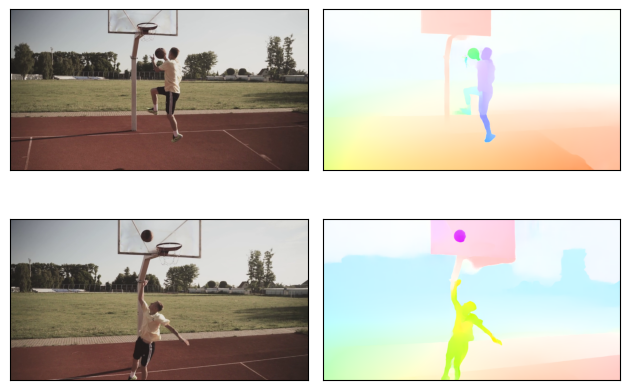

In [10]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

## 额外奖励：创建预测流量的 GIF

在上述示例中，我们仅展示了2对帧的预测流量。有趣的应用光学流模型的方法是对整个视频运行该模型，并根据所有预测的流量创建一个新的视频。下面是可以帮助你开始这个过程的代码片段。由于这个例子是在没有 GPU 的机器上渲染的，注释掉了代码，因为运行它将花费太长时间。

In [12]:
# from torchvision.io import write_jpeg
# for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
#     # Note: it would be faster to predict batches of flows instead of individual flows
#     img1, img2 = preprocess(img1, img2)

#     list_of_flows = model(img1.to(device), img2.to(device))
#     predicted_flow = list_of_flows[-1][0]
#     flow_img = flow_to_image(predicted_flow).to("cpu")
#     output_folder = "/tmp/"  # Update this to the folder of your choice
#     write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

一旦 `.jpg` 格式的流动图像被保存，你可以使用 `ffmpeg` 将它们转换为视频或 GIF。例如：

```bash
ffmpeg -f image2 -framerate 30 -i predicted_flow_%d.jpg -loop -1 flow.gif
```